**Construcción de dataset de análisis**

In [1]:
import pandas as pd

dataset1 = "viajeros-hospedados-residentes-y-no-residentes-por-destino.csv"
datos1 = pd.read_csv(dataset1)
cant_viajeros_res_nores = datos1.iloc[:, :4]

In [2]:
dataset2 = "estadia-media-residentes-y-no-residentes-por-destino.csv"
datos2 = pd.read_csv(dataset2)
estadia_media_res_nores = datos2.iloc[:, :4]

In [5]:
dataset3 = "tasas-de-ocupacion-plazas-por-region-y-categoria.csv"
datos3 = pd.read_csv(dataset3)
tasas_ocup_plazas = datos3.iloc[:, :4]

In [7]:
dataset4 = "tasas-de-ocupacion-habitacion-por-region-y-categoria.csv"
datos4 = pd.read_csv(dataset4)
tasas_ocup_habit = datos4.iloc[:, :4]

In [9]:
dataset5 = "facturacion-total-en-pesos-por-region-y-categoria.csv"
datos5 = pd.read_csv(dataset5)
factu_region_categ = datos5.iloc[:, :4]

In [138]:
data1 = cant_viajeros_res_nores.merge(estadia_media_res_nores, on=['indice_tiempo', 'region_de_destino', 'origen_viajeros'], how='outer')

In [140]:
data2 = tasas_ocup_plazas.merge(tasas_ocup_habit, on=['indice_tiempo', 'region_de_destino', 'categoria_del_hotel'], how='outer').merge(factu_region_categ, on=['indice_tiempo', 'region_de_destino', 'categoria_del_hotel'], how='outer')

---------------------------------------

**Dataset definitivo**

In [189]:
data = data1.merge(data2, on=['indice_tiempo', 'region_de_destino'], how='outer')
data.head()

,indice_tiempo,region_de_destino,origen_viajeros,viajeros,estadia_media_en_noches,categoria_del_hotel,tasa_de_ocupacion_plazas,tasa_de_ocupacion_habitaciones,facturacion_total_en_pesos
0,2007-01-01,Buenos Aires,Residentes,401221.0,5.3,NaN,NaN,NaN,NaN
1,2007-01-01,Buenos Aires,No residentes,12889.0,3.8,NaN,NaN,NaN,NaN
2,2007-01-01,Buenos Aires,Total,NaN,5.3,NaN,NaN,NaN,NaN
3,2007-01-01,CABA,Residentes,139181.0,2.3,NaN,NaN,NaN,NaN
4,2007-01-01,CABA,No residentes,196750.0,2.4,NaN,NaN,NaN,NaN


______________________________

In [66]:
import matplotlib.pyplot as plt

**¿Cómo fue la evolución del número de viajeros residentes entre 2020 y 2024? ¿Cuáles fueron las regiones más populares en el tiempo?**

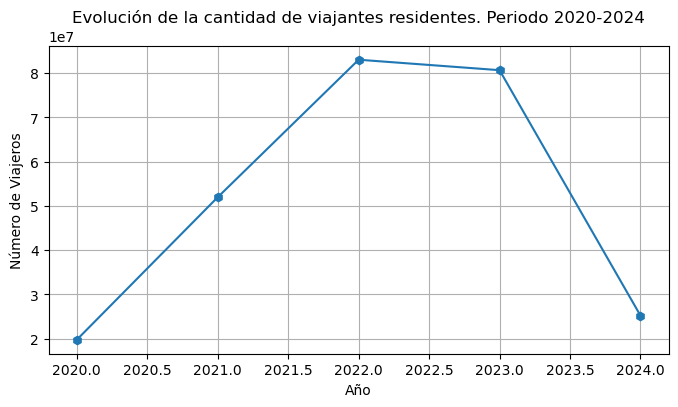

In [107]:
data['indice_tiempo'] = pd.to_datetime(data['indice_tiempo'])
tiempo_filtrado = data[(data['indice_tiempo'].dt.year >= 2020) & (data['indice_tiempo'].dt.year <= 2024)]
viajeros_resid = tiempo_filtrado[tiempo_filtrado['origen_viajeros'] == 'Residentes']

# Copia del DataFrame filtrado para evitar SettingWithCopyWarning
viajeros_resid = viajeros_resid.copy()
# Columna 'year' basada en 'indice_tiempo'
viajeros_resid['year'] = viajeros_resid['indice_tiempo'].dt.year

viaj_x_ano = viajeros_resid.groupby('year')['viajeros'].sum()

# Gráfico
plt.figure(figsize=(8, 4))
viaj_x_ano.plot(kind='line', marker='h')
plt.title('Evolución de la cantidad de viajantes residentes. Periodo 2020-2024')
plt.xlabel('Año')
plt.ylabel('Número de Viajeros')
plt.grid(True)
plt.show()

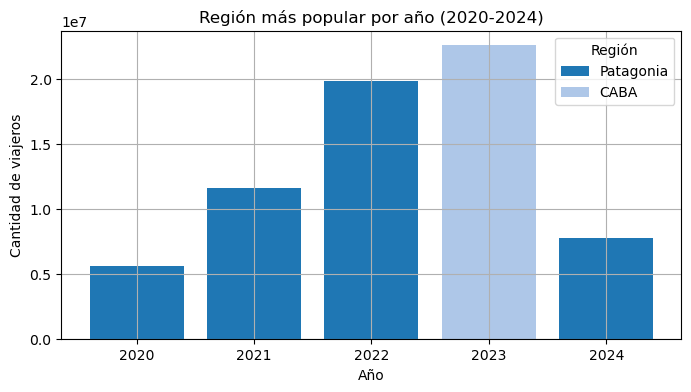

In [136]:
tiempo_filtrado.loc[:, 'year'] = tiempo_filtrado['indice_tiempo'].dt.year
region_x_ano_filtrado = tiempo_filtrado.groupby(['year', 'region_de_destino'])['viajeros'].sum().reset_index()

# Región más popular por año
idx = region_x_ano_filtrado.groupby('year')['viajeros'].idxmax()
regiones_populares = region_x_ano_filtrado.loc[idx]

# Gráfico

# Colores distintos para cada región
unique_regions = regiones_populares['region_de_destino'].unique()
colors = plt.cm.tab20(range(len(unique_regions)))
color_dict = dict(zip(unique_regions, colors))


plt.figure(figsize=(8, 4))
for year in regiones_populares['year'].unique():
    region = regiones_populares[regiones_populares['year'] == year]
    plt.bar(year, region['viajeros'].values[0], label=region['region_de_destino'].values[0], color=color_dict[region['region_de_destino'].values[0]])

# Evitar duplicados en la leyenda
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), title='Región')

plt.title('Región más popular por año (2020-2024)')
plt.xlabel('Año')
plt.ylabel('Cantidad de viajeros')
plt.xticks(regiones_populares['year'].unique())
plt.grid(True)
plt.show()

**Dentro del periodo de las vacaciones de verano del 2020-2021, ¿cómo fue la tasa de ocupación hotelera? ¿El levantamiento de las etapas de la cuarentena ayudó a su incremento con el tiempo?**

Turismo verano 2020-2021

In [109]:
vacac_verano_20_21 = data[(data['indice_tiempo'] >= '2020-12-18') & (data['indice_tiempo'] <= '2021-02-01')]

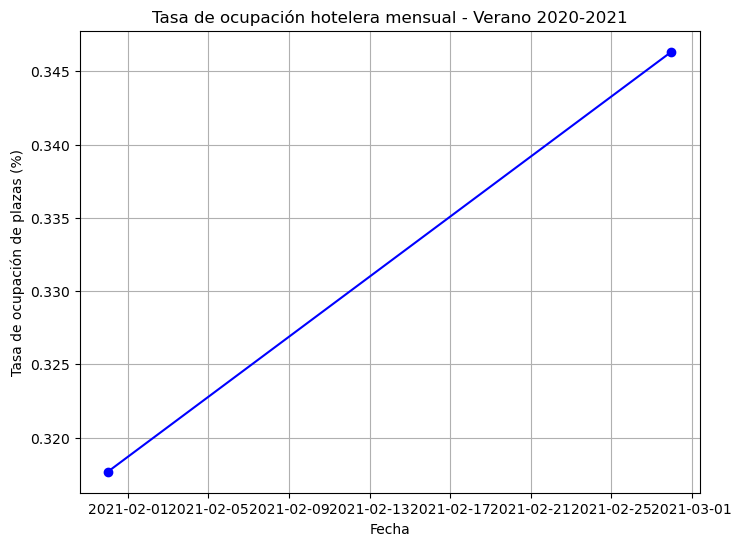

In [177]:
tasa_ocup_mensual = vacac_verano_20_21.resample('M', on='indice_tiempo')['tasa_de_ocupacion_plazas'].mean()

# Gráfico de la tasa de ocupación hotelera mensual
plt.figure(figsize=(8, 6))
plt.plot(tasa_ocup_mensual.index, tasa_ocup_mensual.values, marker='o', linestyle='-', color='blue')
plt.title('Tasa de ocupación hotelera mensual - Verano 2020-2021')
plt.xlabel('Fecha')
plt.ylabel('Tasa de ocupación de plazas (%)')
plt.grid(True)
plt.show()

Turismo pre verano 2020

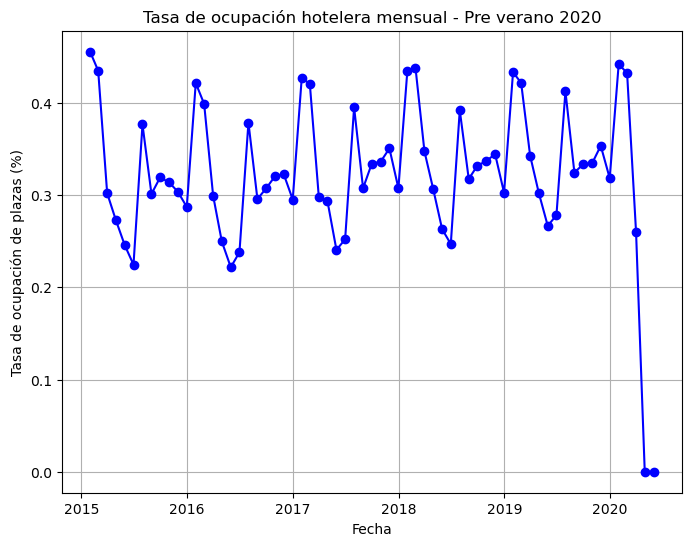

In [187]:
pre_cuarent_2020 = data[(data['indice_tiempo'] <= '2020-12-31') & (data['indice_tiempo'] >= '2015-01-01')]

tasa_ocup_pre2020 = pre_cuarent_2020.resample('M', on='indice_tiempo')['tasa_de_ocupacion_plazas'].mean()

# Gráfico de la tasa de ocupación hotelera mensual
plt.figure(figsize=(8, 6))
plt.plot(tasa_ocup_pre2020.index, tasa_ocup_pre2020.values, marker='o', linestyle='-', color='blue')
plt.title('Tasa de ocupación hotelera mensual - Pre verano 2020')
plt.xlabel('Fecha')
plt.ylabel('Tasa de ocupación de plazas (%)')
plt.grid(True)
plt.show()


**Tener en cuenta que el turismo comienza a tener normalidad entre noviembre y diciembre de 2020.

**Teniendo en cuenta el punto anterior, ¿cuál es la región del país que menos facturación tuvo durante
ese periodo? ¿Hubo algún cambio de preferencia este año?**

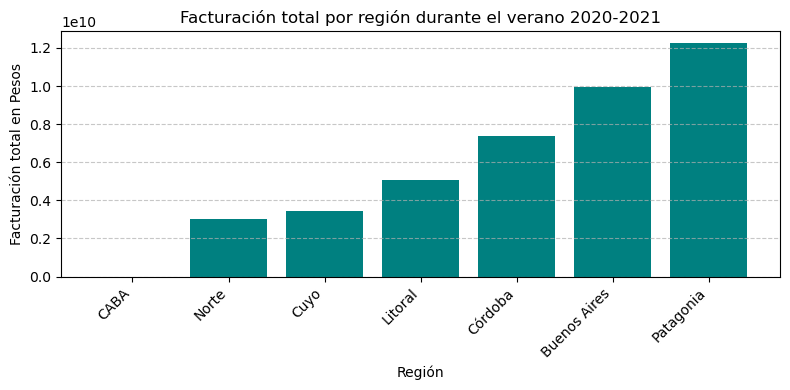

In [220]:
fact_x_region = vacac_verano_20_21.groupby('region_de_destino')['facturacion_total_en_pesos'].sum().reset_index()
region_menor_fact = fact_x_region.loc[fact_x_region['facturacion_total_en_pesos'].idxmin()]
fact_x_region = fact_x_region.sort_values(by='facturacion_total_en_pesos')


# Gráfico de la facturación total por región - verano 2020-2021
plt.figure(figsize=(8, 4))
plt.bar(fact_x_region['region_de_destino'], fact_x_region['facturacion_total_en_pesos'], color='teal')
plt.title('Facturación total por región durante el verano 2020-2021')
plt.xlabel('Región')
plt.ylabel('Facturación total en Pesos')
plt.xticks(rotation=45, ha='right')
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


Regiones según recaudación en el verano 2024

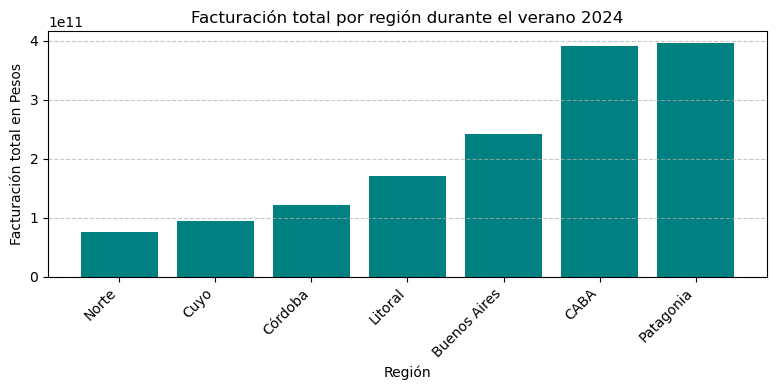

In [237]:
ocup_24 = data[(data['indice_tiempo'] >= '2024-01-01') & (data['indice_tiempo'] <= '2024-03-01')]

fact_x_region_2024 = ocup_24.groupby('region_de_destino')['facturacion_total_en_pesos'].sum().reset_index()
region_fact_2024 = fact_x_region_2024.loc[fact_x_region_2024['facturacion_total_en_pesos'].idxmin()]
fact_x_region_2024 = fact_x_region_2024.sort_values(by='facturacion_total_en_pesos')

# Gráfico de la facturación total por región - verano 2024
plt.figure(figsize=(8, 4))
plt.bar(fact_x_region_2024['region_de_destino'], fact_x_region_2024['facturacion_total_en_pesos'], color='teal')
plt.title('Facturación total por región durante el verano 2024')
plt.xlabel('Región')
plt.ylabel('Facturación total en Pesos')
plt.xticks(rotation=45, ha='right')
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

**¿Qué categorías de alojamiento fueron las más exitosas en ocupación entre 2022 y 2024?
¿Demuestra algún tipo de progreso económico o no**?

Ocupación 2022-2024

In [27]:
ocup_22_24 = data[(data['indice_tiempo'] >= '2022-01-01') & (data['indice_tiempo'] <= '2024-04-01')]

In [29]:
ocup_22_24.loc[:, 'viajeros'] = ocup_22_24['viajeros'].fillna(0)
ocup_22_24.loc[:, 'facturacion_total_en_pesos'] = ocup_22_24['facturacion_total_en_pesos'].fillna(0)

In [31]:
ocup_filtrado = ocup_22_24.groupby('categoria_del_hotel').agg({
    'facturacion_total_en_pesos': 'sum',
    'viajeros': 'sum'
}).reset_index()
ocup_filtrado['ocupacion'] = ocup_filtrado['facturacion_total_en_pesos'] / ocup_filtrado['viajeros']
ocup_2022_2024 = ocup_filtrado.sort_values(by='ocupacion', ascending=False)
ocup_2022_2024

,categoria_del_hotel,facturacion_total_en_pesos,viajeros,ocupacion
2,4 y 5 estrellas,3.200855e+12,46479560.0,68865.873149
1,3 estrellas/boutiques/aparts,1.211391e+12,46479560.0,26062.879323
3,Para Hoteles,5.796830e+11,46479560.0,12471.783430
0,1 y 2 estrellas,3.898394e+11,46479560.0,8387.329031
4,Total,0.000000e+00,46479560.0,0.000000


Ocupación 2020-2022

In [33]:
ocup_20_22 = data[(data['indice_tiempo'] >= '2020-01-01') & (data['indice_tiempo'] <= '2022-12-31')]

In [35]:
ocup_20_22.loc[:, 'viajeros'] = ocup_20_22['viajeros'].fillna(0)
ocup_20_22.loc[:, 'facturacion_total_en_pesos'] = ocup_20_22['facturacion_total_en_pesos'].fillna(0)

In [37]:
ocup_b_filtrado = ocup_20_22.groupby('categoria_del_hotel').agg({
    'facturacion_total_en_pesos': 'sum',
    'viajeros': 'sum'
}).reset_index()
ocup_b_filtrado['ocupacion'] = ocup_b_filtrado['facturacion_total_en_pesos'] / ocup_b_filtrado['viajeros']
ocup_2020_2022 = ocup_b_filtrado.sort_values(by='ocupacion', ascending=False)
ocup_2020_2022

,categoria_del_hotel,facturacion_total_en_pesos,viajeros,ocupacion
2,4 y 5 estrellas,7.428010e+11,35002445.0,21221.404142
1,3 estrellas/boutiques/aparts,2.982648e+11,35002445.0,8521.256206
3,Para Hoteles,1.511486e+11,35002445.0,4318.229207
0,1 y 2 estrellas,9.714372e+10,35002445.0,2775.341033
4,Total,0.000000e+00,35002445.0,0.000000


**Se observa crecimiento en la ocupación.

In [227]:
#REUTILIZAR
mejores_reg_2024 = ocup_2024[(ocup_2024['region_de_destino'] == 'Patagonia') | (ocup_2024['region_de_destino'] == 'Buenos Aires') | (ocup_2024['region_de_destino'] == 'Córdoba')]
mejores_reg_x_resid_2024 = mejores_reg_2024[(mejores_reg_2024['origen_viajeros'] == 'Residentes')]
mejores_reg_x_resid_2024.head()

,indice_tiempo,region_de_destino,origen_viajeros,viajeros,estadia_media_en_noches,categoria_del_hotel,tasa_de_ocupacion_plazas,tasa_de_ocupacion_habitaciones,facturacion_total_en_pesos
16380,2024-01-01,Buenos Aires,Residentes,336435.0,4.8,1 y 2 estrellas,0.58,0.63,5.159626e+09
16381,2024-01-01,Buenos Aires,Residentes,336435.0,4.8,3 estrellas/boutiques/aparts,0.59,0.69,1.342213e+10
16382,2024-01-01,Buenos Aires,Residentes,336435.0,4.8,4 y 5 estrellas,0.51,0.58,7.733565e+09
16383,2024-01-01,Buenos Aires,Residentes,336435.0,4.8,Para Hoteles,0.64,0.72,1.059735e+10
16384,2024-01-01,Buenos Aires,Residentes,336435.0,4.8,Total,0.60,0.67,NaN
